In [1]:
import numpy as np
import pandas as pd
import joblib
import os
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_poisson_deviance, roc_curve, roc_auc_score, jaccard_score

from utils import model_metrics_rms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

os.chdir('/workspace') # change to the root directory of the project

In [2]:
path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"

# Load the data

In [3]:
# Load the normalized MSI data
peaks = pd.read_pickle(f"{path}peaks_filtered_lesion.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered_lesion.pkl")

peaks.shape, pixels.shape

((1720272, 3492), (1720272, 15))

# Define the densities and a threshold for each pixel density

In [4]:
# Determine the densities of the selected pixels
densities = ["Density_CD8", "Density_Tumor", "Density_Stroma", "Density_Collagen"]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

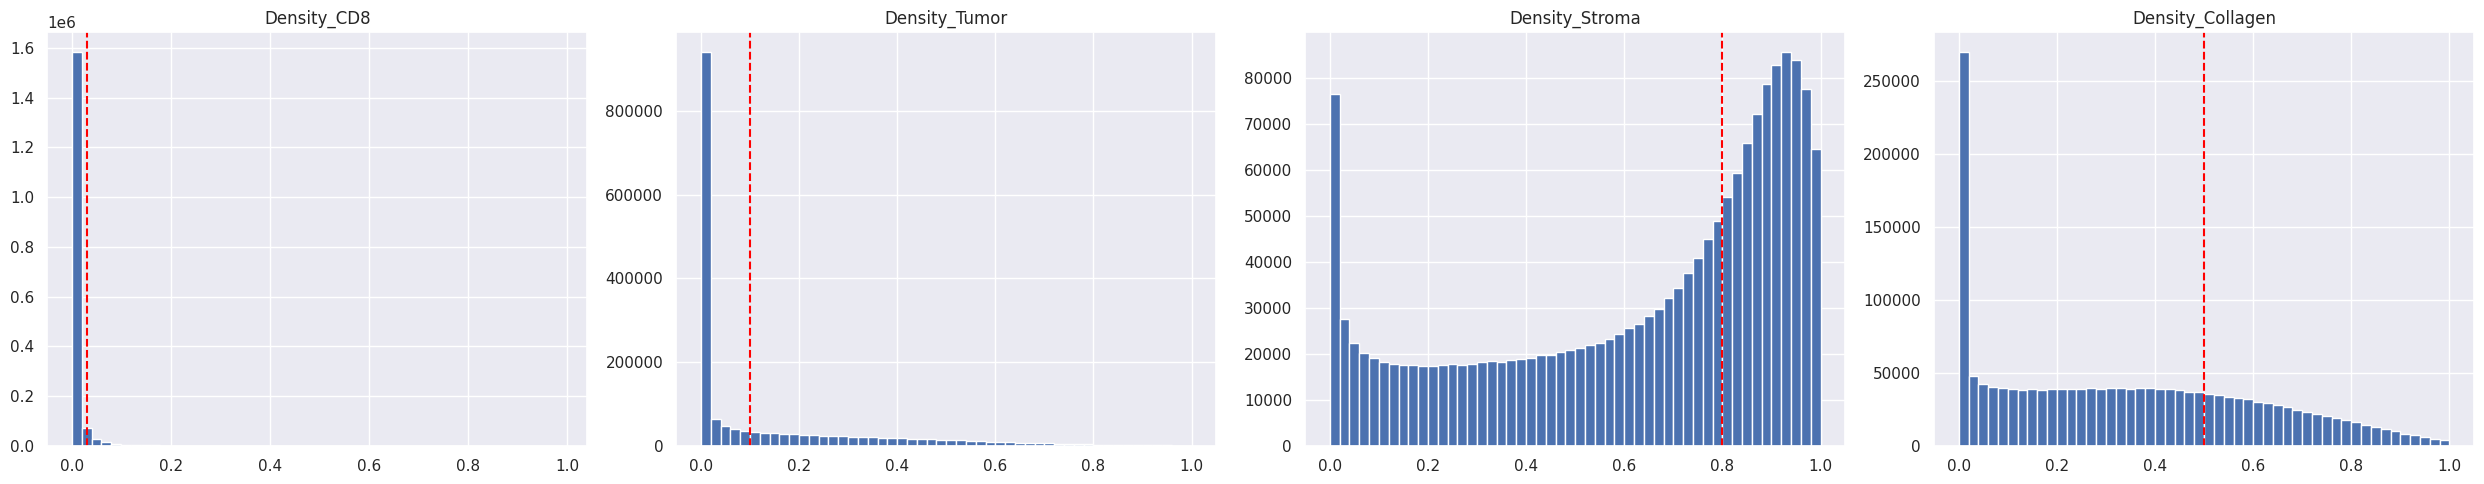

In [5]:
# Plot a histogram of the densities
fig, axes = plt.subplots(1, 4, figsize=(25, 5), tight_layout=True)
for i, (ax, density) in enumerate(zip(axes, densities)):
    ax.hist(pixels[density], bins=50)
    ax.axvline(threshold[density], color='red', linestyle='--')
    ax.set_title(density)
    # ax.set_yscale('log')
plt.show()

# Clean the Defective pixels

In [6]:
# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

# Normalize the data

In [7]:
# Extract the column names of the peaks
peaks_columns = peaks.columns

# Standardize the peaks
scaler = StandardScaler()
peaks = scaler.fit_transform(peaks)
peaks = pd.DataFrame(peaks, columns=peaks_columns)

# Split the data into training and testing sets

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(peaks[pixels["Density_Lesion"] > 0.5].values,
                                                    pixels[pixels["Density_Lesion"] > 0.5]['Density_CD8'].values,
                                                    test_size=0.05,
                                                    random_state=42)

In [ ]:
# Delete the peaks and pixels
del peaks
del pixels

gc.collect()

68

# Transform the target variablem

In [10]:
# Take the root mean square of the densities
y_train_rms = np.sqrt(y_train)
y_test_rms = np.sqrt(y_test)

# Perform a linear regression

In [11]:
# Create a linear regression model
model_reg = LinearRegression()

# Train the model
model_reg.fit(X_train, y_train_rms)

LinearRegression()

R-squared (Train): 0.03
R-squared (Test): 0.03
Mean Squared Error (Train): 4.46e-04
Mean Squared Error (Test): 4.35e-04
Deviance (Train): 2.61e-02
Deviance (Test): 2.57e-02


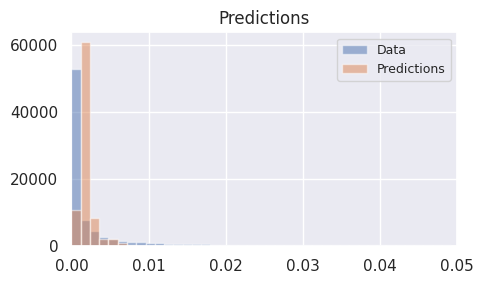

In [12]:
# perform the prediction
_ = model_metrics_rms(model_reg, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [13]:
# Create a laso regression model
model_lasso = Lasso(alpha=0.001, max_iter=10**6, tol=1e-6)

# Train the model
model_lasso.fit(X_train, y_train_rms)

Lasso(alpha=0.001, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.17
R-squared (Test): 0.17
Mean Squared Error (Train): 4.16e-04
Mean Squared Error (Test): 4.06e-04
Deviance (Train): 2.03e-02
Deviance (Test): 2.01e-02


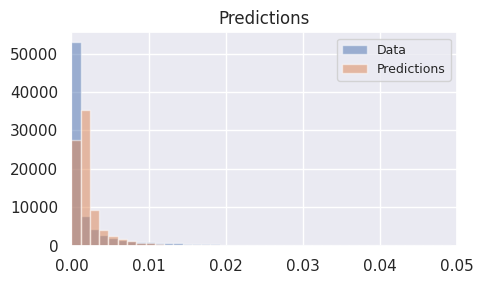

In [14]:
# perform the prediction
_ = model_metrics_rms(model_lasso, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [15]:
# Create a ridge regression model
model_ridge = Ridge(alpha=0.01, max_iter=10**6, tol=1e-6)

# Train the model
model_ridge.fit(X_train, y_train_rms)

/home/vscode/.local/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.87739e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.01, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.24
R-squared (Test): 0.23
Mean Squared Error (Train): 3.83e-04
Mean Squared Error (Test): 3.77e-04
Deviance (Train): 1.74e-02
Deviance (Test): 1.74e-02


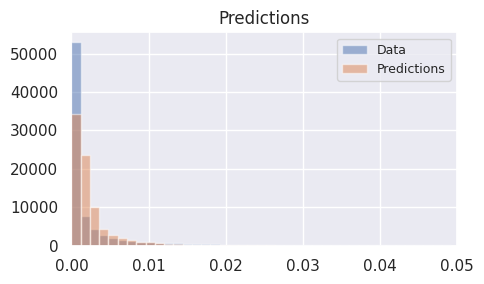

In [16]:
_ = model_metrics_rms(model_ridge, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [17]:
# Create a elastic net regression model
model_en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10**6, tol=1e-6)

# Train the model
model_en.fit(X_train, y_train_rms)

ElasticNet(alpha=0.001, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.19
R-squared (Test): 0.19
Mean Squared Error (Train): 4.07e-04
Mean Squared Error (Test): 3.97e-04
Deviance (Train): 1.94e-02
Deviance (Test): 1.93e-02


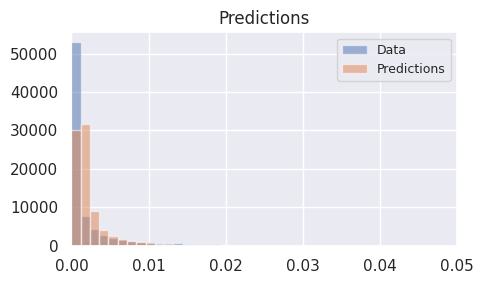

In [18]:
_ = model_metrics_rms(model_en, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [19]:
# Initialize the values
r2_train_list, r2_test_list, mse_train_list, mse_test_list, deviance_train_list, deviance_test_list = [], [], [], [], [], []

# Create a table with the results
for model, name in zip([model_reg, model_lasso, model_ridge, model_en],
                       ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
    
    # Perform the prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute R-squared
    r2_train_list.append(r2_score(y_train_rms, y_pred_train))
    r2_test_list.append(r2_score(y_test_rms, y_pred_test))

    # Square the predictions
    y_pred_train = y_pred_train ** 2
    y_pred_test = y_pred_test ** 2

    # Clip the negative values
    y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
    y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)

    # Compute the mean squared error
    mse_train_list.append(mean_squared_error(y_train, y_pred_train))
    mse_test_list.append(mean_squared_error(y_test, y_pred_test))

    # Compute the deviance
    deviance_train_list.append(mean_poisson_deviance(y_train, y_pred_train))
    deviance_test_list.append(mean_poisson_deviance(y_test, y_pred_test))

# Create a DataFrame with the results
results = pd.DataFrame({'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net'],
                        'R-squared (train)': r2_train_list,
                        'R-squared (test)': r2_test_list,
                        'Mean Squared Error (train)': mse_train_list,
                        'Mean Squared Error (test)': mse_test_list,
                        'Deviance (train)': deviance_train_list,
                        'Deviance (test)': deviance_test_list})
results

,Model,R-squared (train),R-squared (test),Mean Squared Error (train),Mean Squared Error (test),Deviance (train),Deviance (test)
0,Linear Regression,0.026529,0.026410,0.000446,0.000435,0.026059,0.025691
1,Lasso Regression,0.169899,0.168880,0.000416,0.000406,0.020346,0.020145
2,Ridge Regression,0.239811,0.232252,0.000383,0.000377,0.017408,0.017407
3,Elastic Net,0.192831,0.191684,0.000407,0.000397,0.019416,0.019258


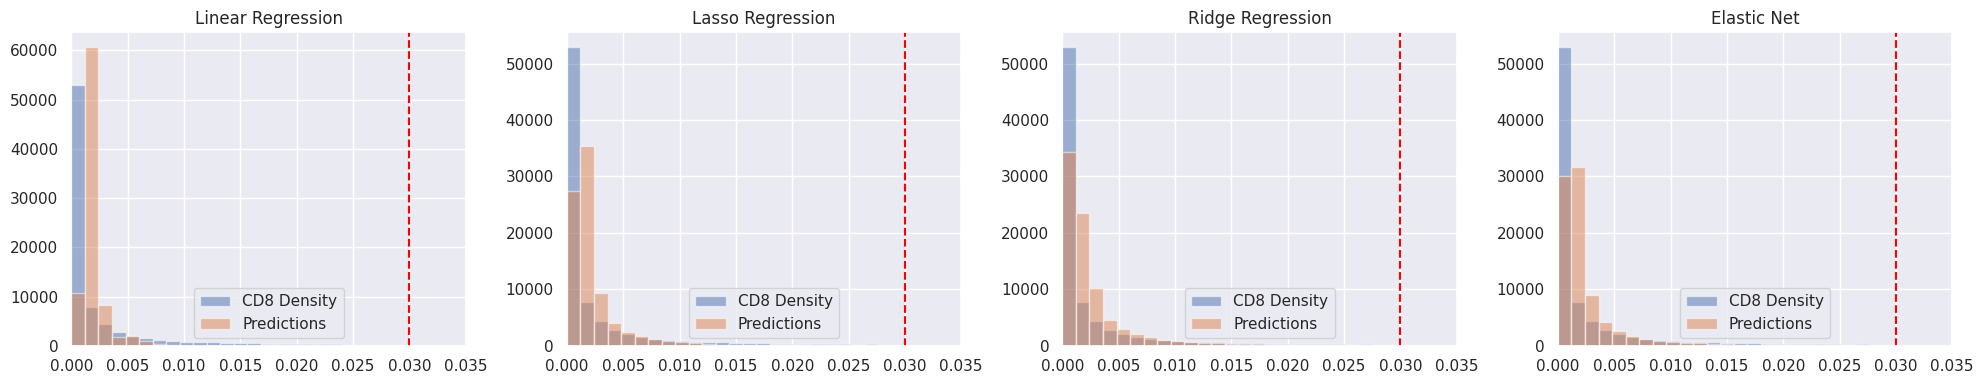

In [20]:
# Plot a histogram of the predictions for all models
fig, axes = plt.subplots(1, 4, figsize=(20, 4), tight_layout=True)

for ax, model, name in zip(axes,
                           [model_reg, model_lasso, model_ridge, model_en],
                           ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
     y_pred_train = model.predict(X_train)
     y_pred_test = model.predict(X_test)
    
     # Square the predictions
     y_pred_train = y_pred_train ** 2
     y_pred_test = y_pred_test ** 2
    
     # Clip the negative values
     y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
     y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)
    
     bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 500)
     ax.hist(y_test, bins=bins, alpha=0.5, label='CD8 Density')
     ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
     ax.axvline(threshold['Density_CD8'], color='red', linestyle='--')
     ax.set_title(name)
     # ax.set_yscale('log')
     ax.set_xlim(0, 0.035)
     ax.legend()
plt.show()

# Save the models

In [ ]:
# save the models
joblib.dump(model_reg, f"{path_models}model_reg.joblib")
joblib.dump(model_lasso, f"{path_models}model_lasso.joblib")
joblib.dump(model_ridge, f"{path_models}model_ridge.joblib")
joblib.dump(model_en, f"{path_models}model_en.joblib")

['data/MALDI_IHC/correlations/results/models/model_en.joblib']

In [8]:
# load the models
model_reg = joblib.load(f"{path_models}model_reg.joblib")
model_lasso = joblib.load(f"{path_models}model_lasso.joblib")
model_ridge = joblib.load(f"{path_models}model_ridge.joblib")
model_en = joblib.load(f"{path_models}model_en.joblib")

In [9]:
# Reload the peaks and pixels data
peaks = pd.read_pickle(f"{path}peaks_filtered.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered.pkl")

# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

In [10]:
# Standardize the peaks with the scaler fitted on the training data
peaks = scaler.transform(peaks)

# Create a DataFrame with the peaks
peaks = pd.DataFrame(peaks, columns=peaks_columns)

In [11]:
# Apply the weights to all the peaks
pixels['Reg_CD8'] = np.clip(a=model_reg.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_Lasso_CD8'] = np.clip(a=model_lasso.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_Ridge_CD8'] = np.clip(a=model_ridge.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_ElasticNet_CD8'] = np.clip(a=model_en.predict(peaks.values) ** 2, a_min=0, a_max=1)

In [13]:
predictions = ['Density_CD8', 'Reg_CD8', 'Reg_Ridge_CD8', 'Reg_Lasso_CD8', 'Reg_ElasticNet_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=5, figsize=(25, 100), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels[pixels['run'] == lame]
    max_density = np.quantile(pixels_lame['Density_CD8'], 0.99)
    for j, prediction in enumerate(predictions):
        axs[i, j].scatter(x=pixels_lame['x_warped'], y=pixels_lame['y_warped'], c=pixels_lame[prediction],
                          s=(pixels_lame['x_warped'].max() - pixels_lame['x_warped'].min()) / len(pixels_lame),
                          marker='s', cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99))
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('equal')
        axs[i, j].invert_yaxis()
        fig.colorbar(axs[i, j].collections[0], ax=axs[i, j])
plt.savefig(f"{path_results}predictions_CD8.png")
plt.close()